In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os

# Subir tres niveles desde tfm/teams/sheffield/ hasta data/
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.insert(0, project_root)

from database.connection import get_db_manager

In [2]:
# Configuration
TABLE_TYPE = 'domestic'
LEAGUES = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']
SEASON = '2324'
MIN_MINUTES = 800

VILLARREAL_COLORS = {
    'primary': '#FFE500',
    'secondary': '#005187'
}

BETIS_COLORS = {
    'primary': '#00954C',
    'secondary': '#FFFFFF'
}

FW_PLAYERS = [
    {'name': 'Ben Brereton Díaz', 'search': 'Brereton', 'pos': 'FW', 'team': 'Villarreal'},
    {'name': 'Ayoze Pérez', 'search': 'Ayoze', 'pos': 'FW', 'team': 'Villarreal'},
]

SAVE_PATH_BASE = "./brereton_ayoze_radars/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [3]:
# Conexión BD
db = get_db_manager()

league_list_str = "', '".join(LEAGUES)
query = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_{TABLE_TYPE} p
WHERE p.league IN ('{league_list_str}')
AND p.season = '{SEASON}'
ORDER BY p.league, p.season DESC, p.team, p.player_name
"""

df_raw = pd.read_sql(query, db.engine)
db.close()

print(f"Extraídos: {df_raw.shape[0]} registros, {df_raw.shape[1]} columnas")
df_raw.head()

2025-12-18 18:20:29,978 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-12-18 18:20:30,080 - database.connection - INFO - Database connection successful


Extraídos: 2774 registros, 10 columnas


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
0,3812f10db382a575,Aaron Ramsdale,Arsenal,ENG-Premier League,2324,GK,ENG,25,"{'CS': '2', 'FK': '0', 'OG': '0', '/90': '-0.2...","{'understat_xa': '0.0', 'understat_team': 'Ars..."
1,4297cac0772af3c8,Ben White,Arsenal,ENG-Premier League,2324,DF,ENG,25,"{'CS': '1', 'FK': '0', 'OG': '0', '/90': '-0.2...","{'understat_xa': '4.758832193911076', 'underst..."
2,258ed61985702bb2,Bukayo Saka,Arsenal,ENG-Premier League,2324,FW,ENG,21,"{'FK': '0', 'OG': '0', 'Crs': '181', 'Fld': '6...","{'understat_xa': '11.325986489653587', 'unders..."
3,7e4915975dddbf21,Cédric Soares,Arsenal,ENG-Premier League,2324,DF,POR,31,"{'FK': '0', 'OG': '0', 'Crs': '4', 'Fld': '1',...","{'understat_xa': '0.0', 'understat_team': 'Ars..."
4,57f809b3be3768e0,David Raya,Arsenal,ENG-Premier League,2324,GK,ESP,27,"{'CS': '16', 'FK': '0', 'OG': '0', '/90': '-0....","{'understat_xa': '0.0', 'understat_team': 'Ars..."


In [4]:
# Filtrar por minutos mínimos Y posición FW
df_filtered = df_raw[
    (df_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES) &
    (df_raw['position'].str.contains('FW', case=False, na=False))
].copy()

print(f"Filtro {MIN_MINUTES}+ min + FW: {df_filtered.shape[0]} jugadores")

Filtro 800+ min + FW: 508 jugadores


In [5]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

In [6]:
# Extraer métricas numéricas
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")

FBref: 185 métricas | Understat: 10 métricas


In [7]:
# Métricas a excluir de per90
exclude_per90 = {
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'minutes_played', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id'
}

# Calcular per90 FBref
fbref_per90 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_per90)]
fbref_per90 = (fbref_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
fbref_per90.columns = [f'{col}_per90' for col in fbref_per90.columns]

# Calcular per90 Understat
understat_per90 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_per90)]
understat_per90 = (understat_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
understat_per90.columns = [f'{col}_per90' for col in understat_per90.columns]

print(f"Per90: {fbref_per90.shape[1]} + {understat_per90.shape[1]}")

# COMBINAR todas las métricas
all_metrics = pd.concat([fbref_nums, understat_nums, fbref_per90, understat_per90], axis=1)

Per90: 154 + 7


In [8]:
# Calcular percentiles
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]

print(f"Métricas totales: {all_metrics.shape[1]}")
print(f"Percentiles totales: {all_percentiles.shape[1]}")

Métricas totales: 356
Percentiles totales: 356


In [9]:
# DataFrame final consolidado
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    all_metrics,
    all_percentiles
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

# Limpieza de Series anidados
def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        if series_mask.any():
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)

# Eliminar columnas problemáticas
problem_cols = ['shots_on_target_pct']
df_final = df_final.drop(columns=[col for col in problem_cols if col in df_final.columns])

print(f"Limpieza completada: {df_final.shape[1]} columnas finales")

DataFrame final: 508 filas, 718 columnas
Limpieza completada: 716 columnas finales


In [10]:
# Search FW players
player_ids = {}

print("FORWARD PLAYER SEARCH:")
print("=" * 50)

for player_config in FW_PLAYERS:
    player_name = player_config['name']
    search_pattern = player_config['search']
    
    search_results = df_filtered[
        df_filtered['player_name'].str.contains(search_pattern, case=False, na=False)
    ]
    
    if len(search_results) > 0:
        print(f"\n{player_name} - search: '{search_pattern}':")
        for _, p in search_results.iterrows():
            minutes = p['fbref_metrics'].get('minutes_played', 0) if isinstance(p['fbref_metrics'], dict) else 0
            print(f"  {p['unique_player_id']} - {p['player_name']} ({p['team']}, {p['league']}, {p['position']}) - {minutes} min")
            
            if player_name not in player_ids:
                player_ids[player_name] = p['unique_player_id']
                print(f"  ✓ ASSIGNED: {player_name} -> {p['unique_player_id']}")
                break
    else:
        print(f"\n{player_name}: NOT FOUND")

print("\n" + "=" * 50)
print("PLAYERS FOUND:")
for name, player_id in player_ids.items():
    print(f"  {name}: {player_id}")

if len(player_ids) == 2:
    print(f"\n✓ ALL PLAYERS FOUND")
else:
    print(f"\n✗ MISSING PLAYERS")

FORWARD PLAYER SEARCH:

Ben Brereton Díaz - search: 'Brereton':
  859f713390732d2a - Ben Brereton (Sheffield Utd, ENG-Premier League, FW,MF) - 1105.0 min
  ✓ ASSIGNED: Ben Brereton Díaz -> 859f713390732d2a

Ayoze Pérez - search: 'Ayoze':
  1dc1d9419b82ed73 - Ayoze Pérez (Betis, ESP-La Liga, FW) - 2294.0 min
  ✓ ASSIGNED: Ayoze Pérez -> 1dc1d9419b82ed73

PLAYERS FOUND:
  Ben Brereton Díaz: 859f713390732d2a
  Ayoze Pérez: 1dc1d9419b82ed73

✓ ALL PLAYERS FOUND


In [11]:
'''
DELANTERO CENTRO (10 métricas) - LISTA DEFINITIVA:

1. expected_goals
2. goals
3. shots
4. Touches_Att Pen
5. expected_assists
6. Take-Ons_Succ
7. npxG/Sh
8. G-xG
9. Fld
10. shot creating actions

EXTREMO (10 métricas) - LISTA DEFINITIVA:

1. expected_goals
2. shots  
3. expected_assists
4. Take-Ons_Succ
5. Touches_Att Pen
6. SCA_SCA90
7. Crs
8. Carries_PrgC
9. npxG/Sh
10. Fld

DEFENSA CENTRAL (10 métricas) - LISTA DEFINITIVA:

1. pass_completion_pct
2. Challenges_Tkl%
3. Aerial Duels_Won
4. Aerial Duels_Won%
5. Launched_Cmp
6. clearances
7. progressive_passes
8. Tkl+Int
9. interceptions
10. Blocks_Sh

LATERAL (10 métricas) - LISTA DEFINITIVA:

1. pass_completion_pct
2. progressive_passes
3. Carries_PrgC
4. Crs
5. passes_penalty_area
6. expected_assists
7. Touches_Att 3rd
8. Tkl+Int
9. Challenges_Tkl%
10. Take-Ons_Succ

MEDIOCENTRO (10 métricas) - LISTA DEFINITIVA EN ORDEN COHERENTE:

1. progressive_passes
2. Carries_PrgC
3. SCA_SCA90
4. expected_assists
5. passes_penalty_area
6. Take-Ons_Succ
7. Tkl+Int
8. interceptions
9. Fld
10. pass_completion_pct

PIVOTE (10 métricas) - LISTA DEFINITIVA:

1. pass_completion_pct
2. progressive_passes
3. Tkl+Int
4. interceptions
5. Challenges_Tkl%
6. Carries_PrgC
7. SCA_SCA90
8. Recov
9. Fld
10. expected_assists

PORTERO (10 métricas) - LISTA DEFINITIVA:

1. Save%
2. PSxG+/-
3. CS%
4. GA90
5. pass_completion_pct
6. Launched_Cmp%
7. Goal Kicks_Launch%
8. Sweeper_#OPA/90
9. Sweeper_AvgDist
10. SoT/90
'''

'\nDELANTERO CENTRO (10 métricas) - LISTA DEFINITIVA:\n\n1. expected_goals\n2. goals\n3. shots\n4. Touches_Att Pen\n5. expected_assists\n6. Take-Ons_Succ\n7. npxG/Sh\n8. G-xG\n9. Fld\n10. shot creating actions\n\nEXTREMO (10 métricas) - LISTA DEFINITIVA:\n\n1. expected_goals\n2. shots  \n3. expected_assists\n4. Take-Ons_Succ\n5. Touches_Att Pen\n6. SCA_SCA90\n7. Crs\n8. Carries_PrgC\n9. npxG/Sh\n10. Fld\n\nDEFENSA CENTRAL (10 métricas) - LISTA DEFINITIVA:\n\n1. pass_completion_pct\n2. Challenges_Tkl%\n3. Aerial Duels_Won\n4. Aerial Duels_Won%\n5. Launched_Cmp\n6. clearances\n7. progressive_passes\n8. Tkl+Int\n9. interceptions\n10. Blocks_Sh\n\nLATERAL (10 métricas) - LISTA DEFINITIVA:\n\n1. pass_completion_pct\n2. progressive_passes\n3. Carries_PrgC\n4. Crs\n5. passes_penalty_area\n6. expected_assists\n7. Touches_Att 3rd\n8. Tkl+Int\n9. Challenges_Tkl%\n10. Take-Ons_Succ\n\nMEDIOCENTRO (10 métricas) - LISTA DEFINITIVA EN ORDEN COHERENTE:\n\n1. progressive_passes\n2. Carries_PrgC\n3. SC

In [12]:
# Position metrics configuration
gk_metrics = [
    'Save%', 'PSxG+/-', 'CS%', 'GA90', 'pass_completion_pct',
    'Launched_Cmp%', 'Goal Kicks_Launch%', 'Sweeper_#OPA/90', 'Sweeper_AvgDist', 'SoT/90'
]

gk_titles = [
    'Save %', 'PSxG +/-', 'Clean Sheets %', 'Goals Against', 'Pass Accuracy %',
    'Long Pass %', 'Long Kicks %', 'Sweeper Actions', 'Sweeper Distance', 'Shots Faced /90'
]

df_metrics = [
    'pass_completion_pct', 'Challenges_Tkl%', 'Aerial Duels_Won_per90', 'Aerial Duels_Won%',
    'passes_final_third_per90', 'clearances_per90', 'progressive_passes_per90', 'Tkl+Int_per90',
    'interceptions_per90', 'Blocks_Sh_per90'
]
df_titles = [
    'Pass Accuracy %', 'Tackle Success %', 'Aerial Duels Won', 'Aerial Success %',
    'Final Third Passes', 'Clearances', 'Progressive Passes', 'Tackles + Interceptions',
    'Interceptions', 'Shot Blocks'
]

lateral_metrics = [
    'pass_completion_pct', 'progressive_passes_per90', 'Carries_PrgC_per90', 'Crs_per90',
    'passes_penalty_area_per90', 'expected_assists_per90', 'Touches_Att 3rd_per90', 
    'Tkl+Int_per90', 'Challenges_Tkl%', 'Take-Ons_Succ_per90'
]
lateral_titles = [
    'Pass Accuracy %', 'Progressive Passes', 'Progressive Carries', 'Crosses',
    'Box Passes', 'Expected Assists', 'Touches Final Third', 
    'Tackles + Interceptions', 'Tackle Success %', 'Dribbles'
]

mf_metrics = [
    'progressive_passes_per90', 'Carries_PrgC_per90', 'SCA_SCA90', 'expected_assists_per90',
    'passes_penalty_area_per90', 'Take-Ons_Succ_per90', 'Tkl+Int_per90', 'interceptions_per90',
    'Fld_per90', 'pass_completion_pct'
]
mf_titles = [
    'Progressive Passes', 'Progressive Carries', 'Shot Creating Actions', 'Expected Assists',
    'Box Passes', 'Dribbles', 'Tackles + Interceptions', 'Interceptions',
    'Fouls Drawn', 'Pass Accuracy %'
]

pivote_metrics = [
    'pass_completion_pct', 'progressive_passes_per90', 'Tkl+Int_per90', 'interceptions_per90',
    'Challenges_Tkl%', 'Carries_PrgC_per90', 'SCA_SCA90', 'Recov_per90',
    'Fld_per90', 'expected_assists_per90'
]
pivote_titles = [
    'Pass Accuracy %', 'Progressive Passes', 'Tackles + Interceptions', 'Interceptions',
    'Tackle Success %', 'Progressive Carries', 'Shot Creating Actions', 'Recoveries',
    'Fouls Drawn', 'Expected Assists'
]

extremo_metrics = [
    'expected_goals_per90', 'shots_per90', 'expected_assists_per90', 'Take-Ons_Succ_per90',
    'Touches_Att Pen_per90', 'SCA_SCA90', 'Crs_per90', 'Carries_PrgC_per90',
    'npxG/Sh', 'Fld_per90'
]
extremo_titles = [
    'Expected Goals', 'Shots', 'Expected Assists', 'Dribbles',
    'Touches in Box', 'Shot Creating Actions', 'Crosses', 'Progressive Carries',
    'npxG per Shot', 'Fouls Drawn'
]

fw_metrics = [
    'expected_goals_per90', 'goals_per90', 'shots_per90', 'Touches_Att Pen_per90',
    'expected_assists_per90', 'Take-Ons_Succ_per90', 'npxG/Sh', 'G-xG_per90',
    'Fld_per90', 'SCA_SCA90'
]
fw_titles = [
    'Expected Goals', 'Goals', 'Shots', 'Touches in Box',
    'Expected Assists', 'Dribbles', 'npxG per Shot', 'Goals - xG',
    'Fouls Drawn', 'Shot Creating Actions'
]

configs = [
    ('GK', gk_metrics, gk_titles),
    ('DF Central', df_metrics, df_titles),
    ('DF Lateral', lateral_metrics, lateral_titles),
    ('MF', mf_metrics, mf_titles),
    ('MF Pivote', pivote_metrics, pivote_titles),
    ('FW Extremo', extremo_metrics, extremo_titles),
    ('FW Centro', fw_metrics, fw_titles)
]

print("POSITION METRICS VERIFICATION:")
print("=" * 50)
for pos, metrics, titles in configs:
    status = "OK" if len(metrics) == 10 and len(titles) == 10 else "ERROR"
    print(f"{status} {pos}: {len(metrics)} metrics, {len(titles)} titles")

print(f"\nTOTAL POSITIONS: {len(configs)}")

POSITION METRICS VERIFICATION:
OK GK: 10 metrics, 10 titles
OK DF Central: 10 metrics, 10 titles
OK DF Lateral: 10 metrics, 10 titles
OK MF: 10 metrics, 10 titles
OK MF Pivote: 10 metrics, 10 titles
OK FW Extremo: 10 metrics, 10 titles
OK FW Centro: 10 metrics, 10 titles

TOTAL POSITIONS: 7


In [13]:
# Brereton vs Ayoze comparison configuration
COMPARISON = {
    'name': 'Brereton_vs_Ayoze',
    'player1': 'Ben Brereton Díaz',
    'player2': 'Ayoze Pérez', 
    'position_type': 'FW_ST',
    'metrics_key': 'fw_st',
    'title': 'Ben Brereton Díaz vs Ayoze Pérez (23/24)',
    'faces': ['/home/jaime/FD/data/blog/caras/tfm/brereton.png', '/home/jaime/FD/data/blog/caras/tfm/Ayoze.png'],
    'colors': [VILLARREAL_COLORS['primary'], BETIS_COLORS['primary']]
}

METRICS_BY_POSITION = {
    'fw_st': {'metrics': fw_metrics, 'titles': fw_titles}
}

print(f"COMPARISON: {COMPARISON['title']}")
print(f"\nMETRICS BY POSITION:")
for position, config in METRICS_BY_POSITION.items():
    metrics_count = len(config['metrics'])
    titles_count = len(config['titles'])
    status = "OK" if metrics_count == 10 and titles_count == 10 else "ERROR"
    print(f"{status} {position}: {metrics_count} metrics, {titles_count} titles")

COMPARISON: Ben Brereton Díaz vs Ayoze Pérez (23/24)

METRICS BY POSITION:
OK fw_st: 10 metrics, 10 titles


FW/ST PLAYER RADAR GENERATION

Processing: Ben Brereton Díaz vs Ayoze Pérez (23/24)
  Dataset: 508 players (FW)
  Teams: Sheffield Utd vs Betis
  Colors: ['#FFE500', '#00954C']
  ✓ Completed: Brereton_vs_Ayoze_combined.png


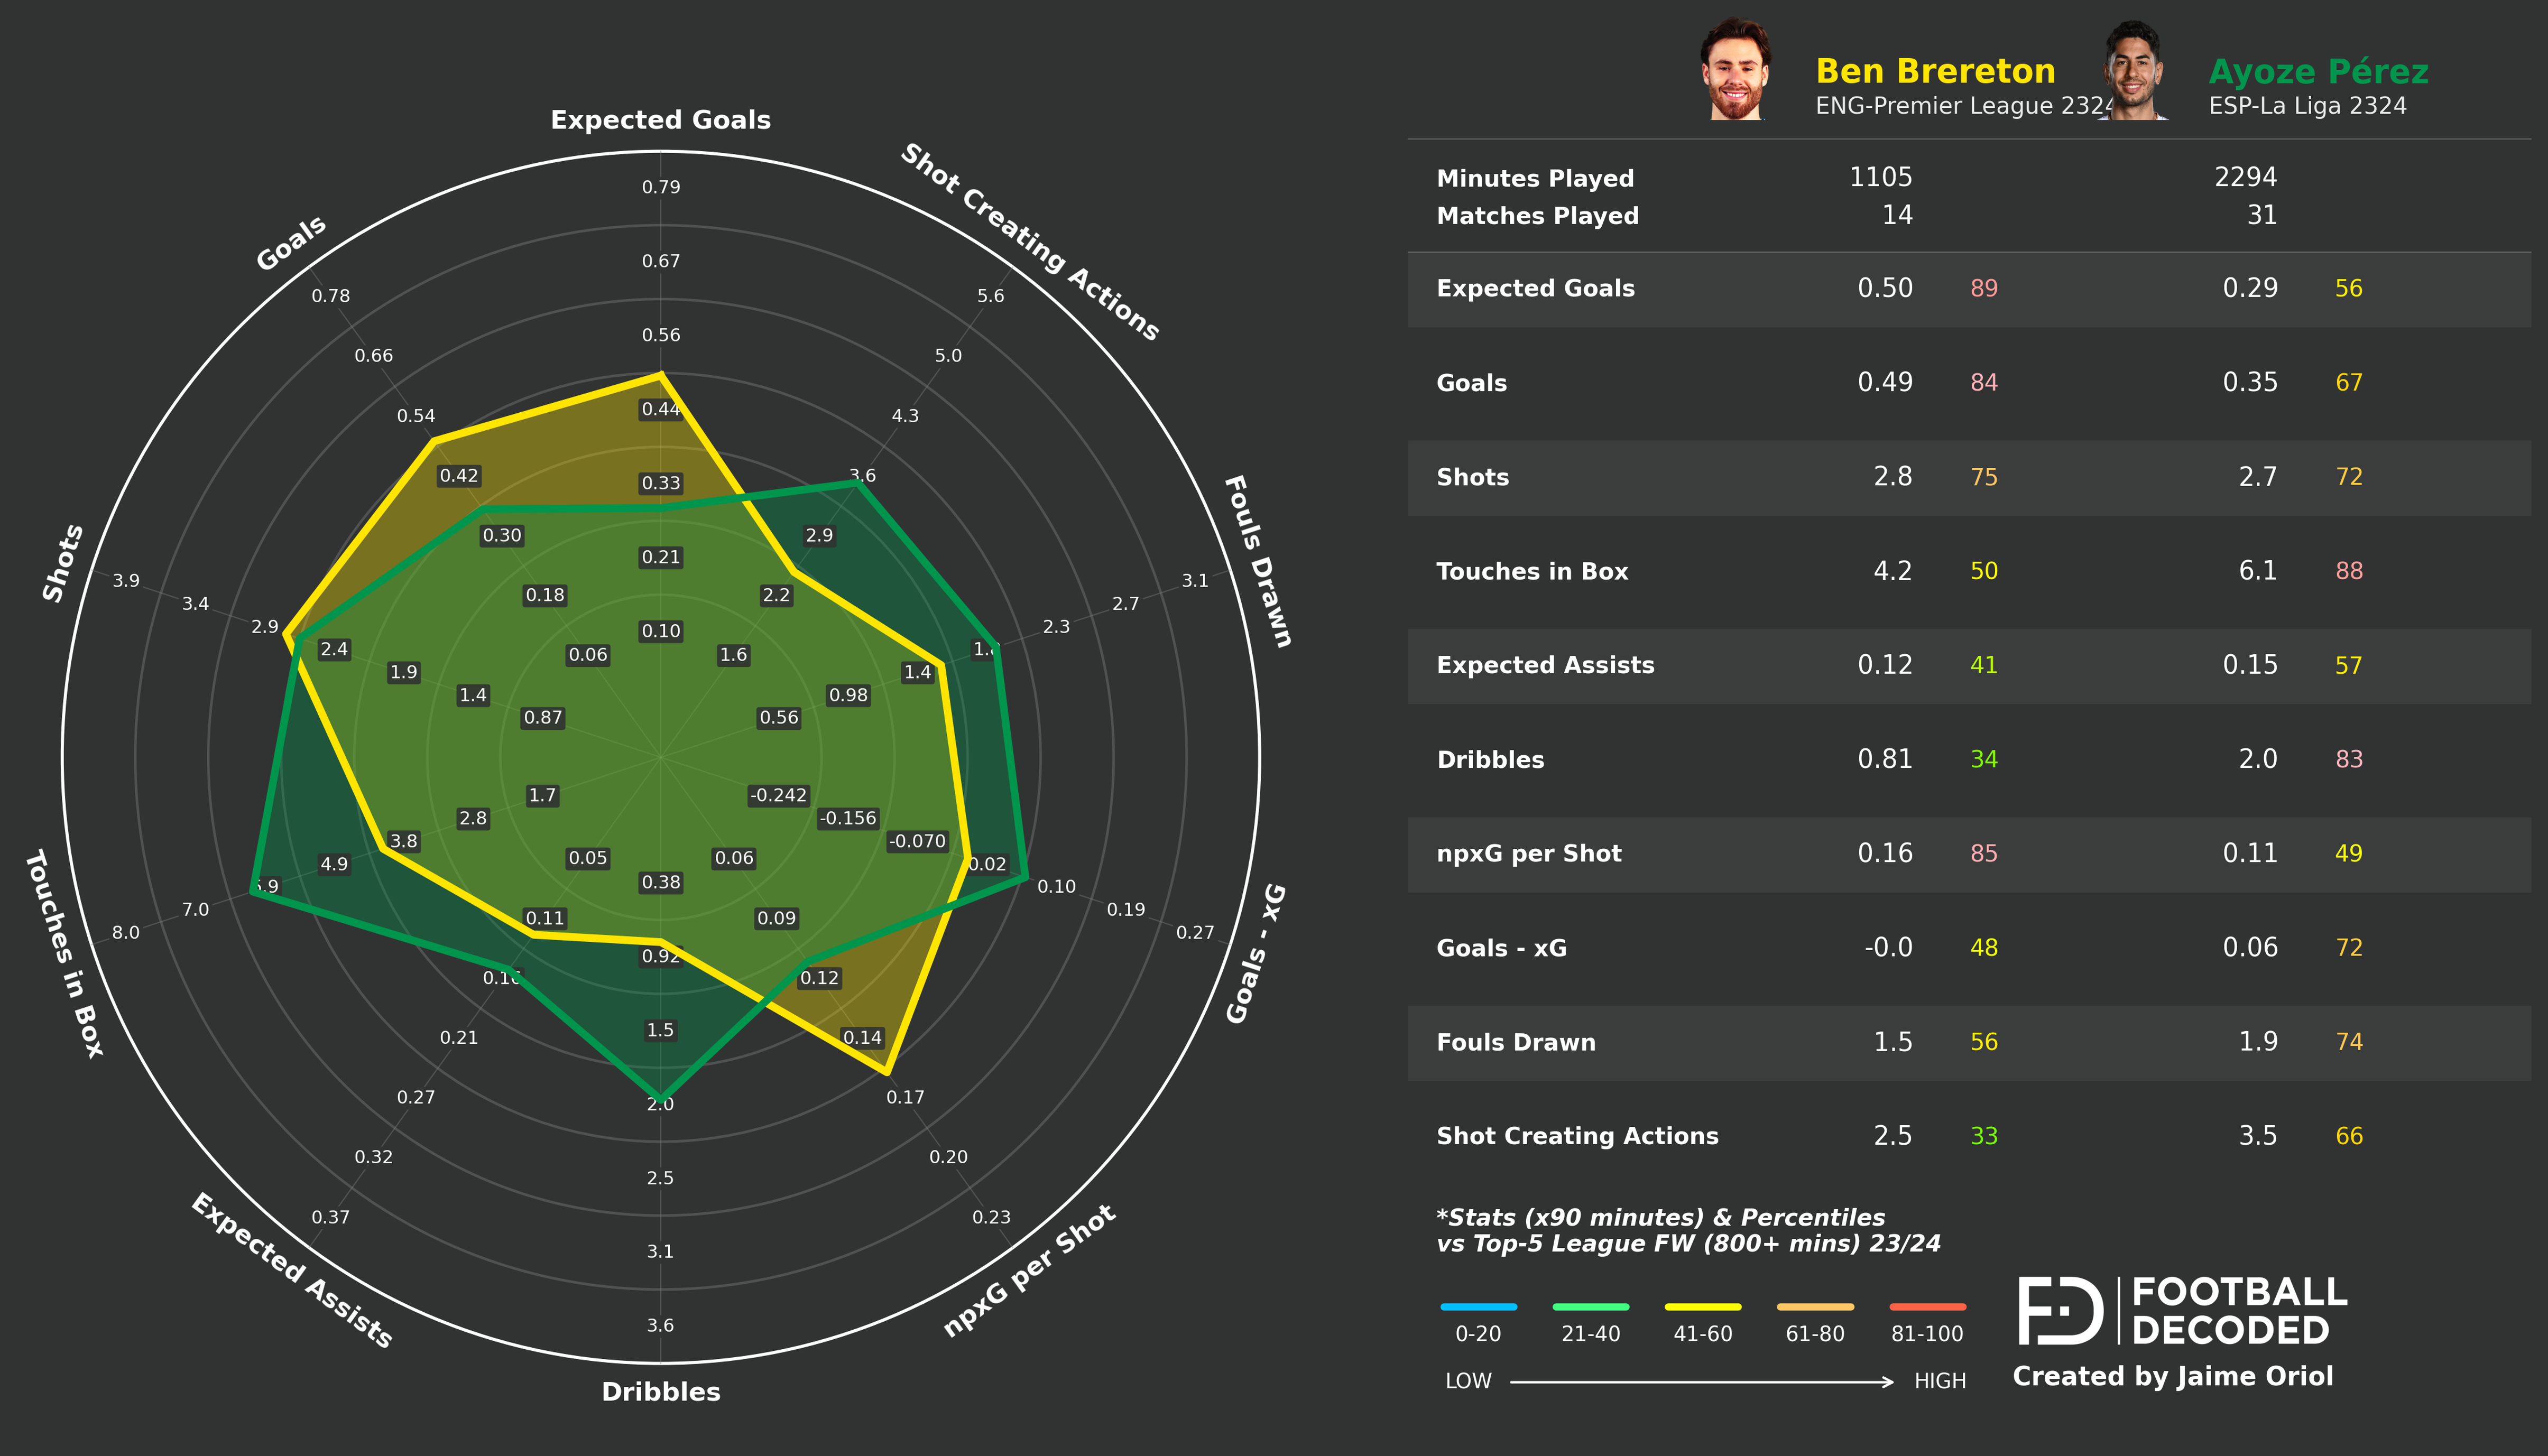


RADAR COMPARISON SUMMARY
✓ Radar generated successfully
Files saved in: ./brereton_ayoze_radars/


In [14]:
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

print("FW/ST PLAYER RADAR GENERATION")
print("=" * 50)

comparison = COMPARISON
config_name = comparison['name']
player1_name = comparison['player1'] 
player2_name = comparison['player2']
title = comparison['title']
faces = comparison['faces']
colors = comparison['colors']
metrics_key = comparison['metrics_key']

print(f"\nProcessing: {title}")

if player1_name not in player_ids or player2_name not in player_ids:
    print(f"Missing player ID")
    print(f"  {player1_name}: {'Found' if player1_name in player_ids else 'Missing'}")
    print(f"  {player2_name}: {'Found' if player2_name in player_ids else 'Missing'}")
else:
    player1_id = player_ids[player1_name]
    player2_id = player_ids[player2_name]
    
    metrics_config = METRICS_BY_POSITION[metrics_key]
    metrics = metrics_config['metrics']
    metric_titles = metrics_config['titles']
    
    # Dataset FW
    position_df = df_final[df_final['position'].str.contains('FW', case=False, na=False)].copy()
    position_filter = "FW"
    
    print(f"  Dataset: {position_df.shape[0]} players ({position_filter})")
    
    # Team names
    player1_team = df_final.loc[df_final['unique_player_id'] == player1_id, 'team'].iloc[0]
    player2_team = df_final.loc[df_final['unique_player_id'] == player2_id, 'team'].iloc[0]
    
    team_colors = colors
    team_logos = {}
    if faces[0]:
        team_logos[player1_team] = faces[0]
    if len(faces) > 1 and faces[1]:
        team_logos[player2_team] = faces[1]
    
    print(f"  Teams: {player1_team} vs {player2_team}")
    print(f"  Colors: {colors}")
    
    try:
        create_player_radar(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            save_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        create_stats_table(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}{config_name}_table.png",
            footer_text=f"Stats (x90 minutes) & Percentiles\nvs Top-5 League {position_filter} ({MIN_MINUTES}+ mins) 23/24",
            show_plot=False
        )
        
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            table_path=f"{SAVE_PATH_BASE}{config_name}_table.png", 
            output_path=f"{SAVE_PATH_BASE}{config_name}_combined.png"
        )
        
        print(f"  ✓ Completed: {config_name}_combined.png")
        
        display(IPImage(f"{SAVE_PATH_BASE}{config_name}_combined.png"))
        
        print("\n" + "=" * 50)
        print("RADAR COMPARISON SUMMARY")
        print("=" * 50)
        print(f"✓ Radar generated successfully")
        print(f"Files saved in: {SAVE_PATH_BASE}")
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        import traceback
        traceback.print_exc()